# Preprocessing the Ames Housing Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df = pd.read_csv("../data/Ames_Housing_Price_Data.csv")
df.drop(['Unnamed: 0'], axis=1, inplace=True)
print(f"Read Ames Housing data from csv. Shape: {df.shape}")

Read Ames Housing data from csv. Shape: (2580, 81)


## Drop duplicates

In [6]:
df[df.PID.duplicated()] # PID 909276070 is a dupe!

,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1817,909276070,1717,194000,50,RL,80.0,12400,Pave,NaN,Reg,...,113,0,NaN,NaN,NaN,0,2,2006,WD,Normal


In [7]:
df.drop_duplicates(inplace=True)

It is unclear why there is one duplicate in the dataset. I initially thought there would be many, as a property could be sold multiple times in the time span of the dataset. However, that appears not to be the case as per the creator of the dataset, Dean De Cock.

See: [http://jse.amstat.org/v19n3/decock.pdf](http://jse.amstat.org/v19n3/decock.pdf)

# Outliers
Reading De Cock's description of the dataset, we find that there are some outliers that we might want to exclude (GrLivArea > 4000)

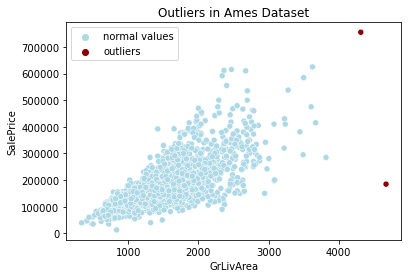

In [23]:
outliers = np.where(df.GrLivArea > 4000, "outliers", "normal values")
sns.scatterplot(x = df.GrLivArea, y = df.SalePrice, hue = outliers, palette = ["lightblue", "darkred"])
plt.title("Outliers in Ames Dataset")
plt.show()

In [ ]:
df = df[df.GrLivArea < 4000]

# Missing Values
The [data description](/data/data_description.txt) tells us that several empty values actually have meaning. Here, we will replace the empty value with the meaning

In [25]:
missingCols = df.isnull().any()
print(f'The columns with missing values are %s {df.columns[missingCols]}')

The columns with missing values are %s Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Electrical',
       'BsmtFullBath', 'BsmtHalfBath', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PoolQC', 'Fence', 'MiscFeature'],
      dtype='object')


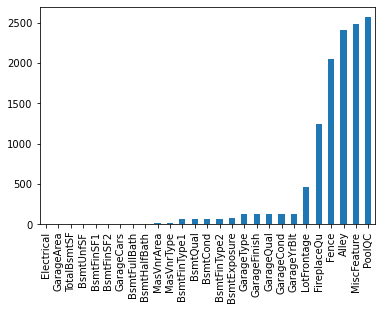

In [26]:
missing = df.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()
plt.show()

For instance, an NA in Alley means that there is no alley for the property